In [1]:
import pandas as pd
import tqdm


KeyboardInterrupt



In [ ]:
hic = pd.read_csv('/home/micl/workspace/lmh_data/Lee2019/BandNorm/bandnorm_result.txt', sep='\t')
hic

In [ ]:
hic_group = hic.groupby('cell')
_hic = pd.DataFrame()
for key in tqdm.notebook.tqdm(hic_group.groups, desc='group'):
    _data = hic_group.get_group(key)
    _data = _data.pivot_table(index=['chrom', 'binA'], values='BandNorm').T
    _data.index = [key]
    _hic = pd.concat([_hic, _data], join='outer')
hic = _hic
hic = hic.fillna(0)
hic

In [ ]:
_hic = anndata.AnnData(X=hic)
_hic.obs['cell_type'] = _hic.obs_names.str.split(r"[:_]").map(lambda x: x[5])

sc.pp.highly_variable_genes(_hic, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(_hic)
sc.pp.log1p(_hic)
sc.pp.scale(_hic)
sc.tl.pca(_hic, n_comps=100, svd_solver="auto")

sc.pp.neighbors(_hic, metric="cosine")
sc.tl.umap(_hic)
sc.pl.umap(_hic, color="cell_type")

In [1]:
import anndata
import numpy as np
import pandas as pd
import networkx as nx
import scanpy as sc
import scglue
from matplotlib import rcParams

In [2]:
hic = anndata.read_h5ad("/home/micl/workspace/lmh_data/Lee2019/scHiC.h5ad")
hic

AnnData object with n_obs × n_vars = 4238 × 309581
    obs: 'domain'
    var: 'chrom', 'start'

In [3]:
hic.obs_names = hic.obs_names.str.split(r"[:_]").map(lambda x: '_'.join(x[:-2]))
hic.obs

,domain
cells,
190315_29yr_6_E11_AD008_ODC,scHiC
181218_21yr_2_B11_AD002_Vip,scHiC
190315_29yr_4_A3_AD006_L5,scHiC
190315_21yr_6_F11_AD012_L23,scHiC
181218_21yr_2_G12_AD010_MP,scHiC
...,...
190305_21yr_2_H6_AD007_MP,scHiC
190305_21yr_2_B1_AD001_OPC,scHiC
190315_21yr_4_C7_AD010_Vip,scHiC


In [4]:
hic_pca = pd.read_csv('/home/micl/workspace/lmh_data/Lee2019/BandNorm/embedding.txt', sep='\t')
hic_pca

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100
181218_21yr_2_A1_AD002_L23.txt,890.902763,83.059109,10.409427,3.083012,-49.354259,-32.600687,14.483734,-18.205280,-41.147020,26.329468,...,-75.735664,-3.820232,36.103463,-27.970191,42.335609,-3.901578,82.587591,-25.758200,-22.978127,96.463360
181218_21yr_2_A1_AD004_L23.txt,904.872698,118.306720,-19.466440,-60.319205,-21.003638,18.145742,13.801854,47.763996,-68.598821,-5.905531,...,49.290660,-67.283106,63.113846,-103.293280,326.277678,169.548997,2.469605,53.261816,-125.220526,152.974825
181218_21yr_2_A1_AD006_L6.txt,919.593825,161.310310,-32.728456,-73.150546,-40.742312,-20.245419,7.219258,23.709505,-42.157936,31.101920,...,-115.939807,134.374472,-152.814060,99.921896,-232.474914,98.563518,-60.032190,-6.316850,-56.298253,279.926732
181218_21yr_2_A1_AD008_ODC.txt,847.266348,-202.626888,68.867497,3.661814,9.588173,18.015434,2.675589,-2.031951,-41.755522,-14.324155,...,-2.210585,-21.356662,31.221962,1.551080,10.824116,-24.044750,12.866632,-16.734417,-11.687963,10.222472
181218_21yr_2_A1_AD010_L5.txt,886.009912,56.243458,10.304221,17.604349,-15.108784,12.878859,24.463045,24.169183,-40.195791,15.401737,...,34.124152,-22.576417,32.882791,18.596894,3.256004,-26.359388,11.476817,19.178504,29.270071,52.927332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190315_29yr_6_H9_AD004_ODC.txt,875.749342,-54.474977,62.063033,-3.718579,-26.856854,0.777472,4.115779,11.823778,5.298375,4.900289,...,-11.239674,2.795996,-4.207720,8.334254,-3.466066,3.272328,13.226099,-7.189493,-6.957192,2.088942
190315_29yr_6_H9_AD006_ODC.txt,869.931323,-76.770471,74.170357,-15.045151,-13.061829,20.001922,1.833363,11.767611,-9.040591,-5.036546,...,6.593132,8.693434,0.491497,-0.642918,0.887359,-0.908937,3.024385,-4.100478,7.214831,-5.355590
190315_29yr_6_H9_AD008_L4.txt,912.004776,184.210110,-38.544711,23.696057,-12.341722,20.049228,-4.100016,16.438967,-12.954493,-6.911907,...,-1.795838,1.604240,5.245884,-0.446017,9.135502,4.044941,-9.760894,2.112579,4.890044,0.847785
190315_29yr_6_H9_AD010_Astro.txt,894.382651,66.583788,10.889655,43.946956,85.647281,-63.064850,15.228112,-24.624083,-2.974911,31.133385,...,-4.625787,-19.812551,-10.425295,16.577477,0.681416,-6.781128,-5.698107,1.316502,-2.404099,2.969823


In [5]:
hic_pca.index = hic_pca.index.str.split(".").map(lambda x: x[0])
hic_pca = hic_pca.loc[hic.obs.index]
hic_pca

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100
cells,,,,,,,,,,,,,,,,,,,,,
190315_29yr_6_E11_AD008_ODC,871.781631,-72.333254,63.865209,-14.608258,-34.432074,9.476109,12.062783,9.782404,-21.597138,2.173983,...,1.046651,-17.042478,14.882015,-16.534655,1.391168,1.037403,0.538673,5.050615,-3.346549,-9.387006
181218_21yr_2_B11_AD002_Vip,899.521570,45.921524,24.171058,-49.777993,26.439545,22.897166,-15.028630,-20.633081,86.418502,7.517671,...,-20.367953,-41.389145,-14.781687,19.157262,-76.522537,25.832940,-19.830331,-19.379901,23.400929,-20.666634
190315_29yr_4_A3_AD006_L5,910.927240,176.876999,-52.440313,0.090915,-12.977546,14.780844,-3.253028,4.845430,-17.316657,-3.052136,...,1.430656,4.287518,-0.204909,5.015617,-5.961964,5.474950,6.702222,-5.824094,1.618371,-8.200665
190315_21yr_6_F11_AD012_L23,895.118014,113.303367,-10.757518,3.634128,-11.863942,21.572154,-18.377858,24.537773,-18.833498,-17.442221,...,-1.133421,7.014512,-2.394452,2.158924,-4.890967,-3.362944,12.538875,0.422184,16.263263,-0.436824
181218_21yr_2_G12_AD010_MP,858.744546,-225.178006,-95.737815,-36.902689,-7.173654,-26.212862,11.680092,-34.620812,-11.160733,12.925413,...,-8.080701,-5.339622,-5.127203,-28.472476,6.222498,35.060980,20.667730,-1.552784,8.225492,13.769378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190305_21yr_2_H6_AD007_MP,857.498332,-149.184302,-83.695044,-22.429992,-20.709749,-15.070855,8.958101,-7.510331,-34.261582,-36.159327,...,0.125220,16.544760,-9.807549,3.689828,-10.374477,-15.048891,-11.979496,5.252029,11.125054,3.911368
190305_21yr_2_B1_AD001_OPC,881.475294,-40.585908,40.154314,33.735235,51.666098,30.628314,-20.095340,10.426129,61.817539,-21.341536,...,-4.706073,-13.534714,4.893264,4.469470,-5.452570,6.212225,-1.512326,-2.814021,1.630196,-16.041625
190315_21yr_4_C7_AD010_Vip,900.474789,108.554408,-17.448108,39.083229,8.888875,44.529691,-28.568607,46.364711,71.446270,-17.628988,...,20.495377,-65.501270,-10.201661,-11.963391,-48.053869,-2.880644,-39.451852,0.294456,57.935249,23.469849


In [6]:
hic.obs["cell_type"] = hic.obs_names.str.split(r"[:_]").map(lambda x: x[5])
hic.obsm["X_pca"] = hic_pca

del hic_pca; import gc; gc.collect();

In [7]:
hic = hic[hic.obs['cell_type'].isin(['Astro', 'Endo', 'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip']),:]
hic.obs

,domain,cell_type
cells,,
190315_29yr_6_E11_AD008_ODC,scHiC,ODC
181218_21yr_2_B11_AD002_Vip,scHiC,Vip
190305_21yr_2_B4_AD002_Vip,scHiC,Vip
190315_21yr_4_G1_AD012_Astro,scHiC,Astro
181218_21yr_2_G7_AD004_Astro,scHiC,Astro
...,...,...
181218_21yr_3_D5_AD010_Vip,scHiC,Vip
190315_21yr_6_G12_AD006_OPC,scHiC,OPC
190305_21yr_2_B1_AD001_OPC,scHiC,OPC


In [8]:
hic.X

ArrayView([[0., 1., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 2., 0., ..., 0., 0., 0.],
           ...,
           [0., 5., 0., ..., 0., 0., 0.],
           [0., 2., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

<AxesSubplot:>

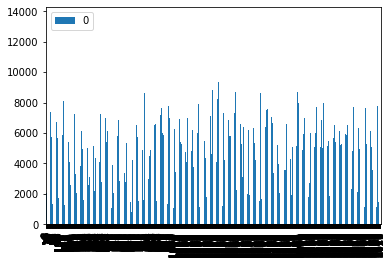

In [9]:
index_max = np.argmax(hic.X, axis=1)
_max = hic.X[range(hic.X.shape[0]), index_max]

pd.DataFrame(_max.T).plot(kind='bar')

In [10]:
# Normalization
_max = hic.X.max(axis=1)
# hic.X = np.round((1/_max).reshape((1/_max).shape[0],1) * hic.X * 255, 0)
hic.X = (1/_max).reshape((1/_max).shape[0],1) * hic.X * 15

In [11]:
rna = anndata.read_h5ad("/home/micl/workspace/lmh_data/Human_M1_10x/scRNA.h5ad")
rna.layers["counts"] = rna.X.copy()
rna

AnnData object with n_obs × n_vars = 22433 × 50281
    obs: 'cell_type', 'domain'
    layers: 'counts'

In [12]:
sc.pp.highly_variable_genes(rna, n_top_genes=100, flavor="seurat_v3")
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

In [13]:
rna

AnnData object with n_obs × n_vars = 22433 × 50281
    obs: 'cell_type', 'domain'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [14]:
scglue.data.get_gene_annotation(
    rna, gtf="/home/micl/workspace/lmh_data/Human_M1_10x/rsem_GRCh38.p2.gtf",
    gtf_by="gene_symbol"
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
DDX11L1,NC_000001.11,11873,14409
WASH7P,NC_000001.11,14361,29370
MIR6859-1,NC_000001.11,17368,17436
MIR1302-2,NC_000001.11,30365,30503
FAM138A,NC_000001.11,34610,36081


In [15]:
def chrom_map(chrom):
    _map = {
        'NC_000001': 'chr1', 'NC_000002': 'chr2', 'NC_000003': 'chr3', 'NC_000004': 'chr4', 'NC_000005': 'chr5',
        'NC_000006': 'chr6', 'NC_000007': 'chr7', 'NC_000008': 'chr8', 'NC_000009': 'chr9', 'NC_000010': 'chr10',
        'NC_000011': 'chr11', 'NC_000012': 'chr12', 'NC_000013': 'chr13', 'NC_000014': 'chr14', 'NC_000015': 'chr15',
        'NC_000016': 'chr16', 'NC_000017': 'chr17', 'NC_000018': 'chr18', 'NC_000019': 'chr19', 'NC_000020': 'chr20',
        'NC_000021': 'chr21', 'NC_000022': 'chr22', 'NC_000023': 'chrX', 'NC_000024': 'chrY', 'NC_012920': 'chrM'
    }
    if chrom in _map.keys():
        return _map[chrom]
    return chrom

rna.var.chrom = rna.var.chrom.str.split(r"[:.]").map(lambda x: chrom_map(x[0]))
rna.var

,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,gene_id
DDX11L1,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,chr1,11873,14409,DDX11L1,.,+,.,.,.,.,.,.,100287102
WASH7P,False,NaN,0.013284,0.013376,0.903725,0.008569,0.084100,chr1,14361,29370,WASH7P,.,-,.,.,.,.,.,.,653635
MIR6859-1,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,chr1,17368,17436,MIR6859-1,.,-,.,.,.,.,.,.,102466751
MIR1302-2,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,chr1,30365,30503,MIR1302-2,.,+,.,.,.,.,.,.,100302278
FAM138A,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,chr1,34610,36081,FAM138A,.,-,.,.,.,.,.,.,645520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND6,False,NaN,0.026301,0.051109,1.680605,0.015903,0.118004,chrM,14148,14673,ND6,.,-,.,.,.,.,.,.,4541
TRNE,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,chrM,14673,14742,TRNE,.,-,.,.,.,.,.,.,4556
CYTB,True,96.0,5.364418,138.183037,4.650733,1.299554,1.010418,chrM,14746,15887,CYTB,.,+,.,.,.,.,.,.,4519
TRNT,False,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,chrM,15887,15953,TRNT,.,+,.,.,.,.,.,.,4576


In [16]:
rna.var[rna.var['highly_variable']==True]

,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,gene_id
RNF220,True,73.0,1.633397,19.891363,5.174512,0.553512,1.143699,chr1,44404782,44651724,RNF220,.,+,.,.,.,.,.,.,55182
BRINP3,True,51.0,2.812598,56.347190,6.012406,0.626851,0.918121,chr1,190097661,190478404,BRINP3,.,-,.,.,.,.,.,.,339479
KCNT2,True,78.0,2.997459,52.718654,5.045081,0.611490,1.066300,chr1,196225778,196608560,KCNT2,.,-,.,.,.,.,.,.,343450
CFH,True,64.0,0.019792,0.122647,5.448604,0.008606,0.113456,chr1,196651877,196747504,CFH,.,+,.,.,.,.,.,.,3075
LINC00299,True,18.0,0.352962,3.726785,7.718043,0.132950,0.515647,chr2,8007770,8328419,LINC00299,.,-,.,.,.,.,.,.,339789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COX2,True,81.0,10.440333,510.512945,5.006267,1.778714,1.131073,chrM,7585,8269,COX2,.,+,.,.,.,.,.,.,4513
ATP6,True,85.0,4.828467,118.782362,4.917386,1.189198,1.009413,chrM,8526,9207,ATP6,.,+,.,.,.,.,.,.,4508
COX3,True,87.0,8.938127,365.021582,4.824936,1.645644,1.109213,chrM,9206,9990,COX3,.,+,.,.,.,.,.,.,4514
ND4,True,90.0,5.388936,141.070325,4.787673,1.290856,1.025941,chrM,10759,12137,ND4,.,+,.,.,.,.,.,.,4538


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


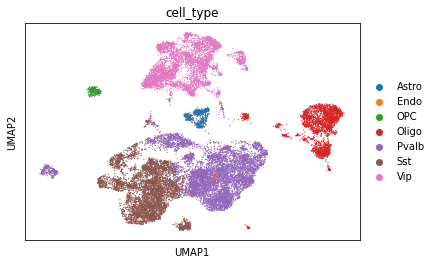

In [17]:
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.pl.umap(rna, color="cell_type")

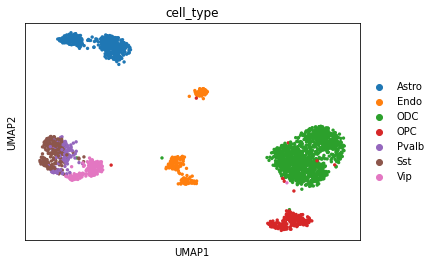

In [18]:
sc.pp.neighbors(hic, use_rep="X_pca", metric="cosine")
sc.tl.umap(hic)
sc.pl.umap(hic, color="cell_type")

In [ ]:
chrom = 'chr8'
start, end = 105780000, 106060000
_index = ['{}_{}'.format(chrom, i) for i in range(start, end+1, 10000)]
# _index = ['{}_{}'.format(chrom, i) for i in [start, end]]
# hic.obs['test'] = hic[:, _index].X
hic.obs['test'] = hic[:, _index].X.mean(axis=1)
sc.pl.umap(hic, color="test")
hic.obs.groupby('cell_type').mean()

In [ ]:
chrom = 'chr3'
start, end = 100740000, 100990000
_index = ['{}_{}'.format(chrom, i) for i in range(start, end+1, 10000)]
# _index = ['{}_{}'.format(chrom, i) for i in [start, end]]
# hic.obs['test'] = hic[:, _index].X
hic.obs['test'] = hic[:, _index].X.mean(axis=1)
sc.pl.umap(hic, color="test")
hic.obs.groupby('cell_type').mean()

In [ ]:
chrom = 'chr13'
start, end = 91390000, 92860000
# _index = ['{}_{}'.format(chrom, i) for i in range(start, end+1, 10000)]
# _index = ['{}_{}'.format(chrom, i) for i in [start+10000, end+10000]]
_index = 'chr13_91380000'
# hic.obs['test'] = hic[:, _index].X
hic.obs['test'] = hic[:, _index].X.mean(axis=1)
sc.pl.umap(hic, color="test")
hic.obs.groupby('cell_type').mean()

In [ ]:
chrom = 'chr12'
start, end = 41180000, 41570000
# _index = ['{}_{}'.format(chrom, i) for i in range(start, end+1, 10000)]
_index = ['{}_{}'.format(chrom, i) for i in [start, end]]
# hic.obs['test'] = hic[:, _index].X
hic.obs['test'] = hic[:, _index].X.mean(axis=1)
sc.pl.umap(hic, color="test")
hic.obs.groupby('cell_type').mean()

In [ ]:
rna.var[rna.var['highly_variable']==True].sort_values(by='highly_variable_rank')[:20]

In [ ]:
rna.obs['test'] = rna[:, 'GPC5'].X
sc.pl.umap(rna, color="test")

In [ ]:
rna.obs['test'] = rna[:, 'ZFPM2-AS1'].X
sc.pl.umap(rna, color="test")

In [ ]:
rna.obs['test'] = rna[:, 'MEPE'].X
sc.pl.umap(rna, color="test")

In [ ]:
_hic = hic.copy()
_hic.X = _hic.X.argsort()

_max = _hic.X.max(axis=1)
_hic.X = (1/_max).reshape((1/_max).shape[0],1) * _hic.X

_hic.X

In [ ]:
chrom = 'chr13'
start, end = 91390000, 92860000
# _index = ['{}_{}'.format(chrom, i) for i in range(start, end+1, 10000)]
# _index = ['{}_{}'.format(chrom, i) for i in [start, end]]
_index = 'chr13_91390000'
# hic.obs['test'] = hic[:, _index].X
_hic.obs['test'] = _hic[:, _index].X.mean(axis=1)
sc.pl.umap(_hic, color="test")
_hic.obs.groupby('cell_type').mean()

In [ ]:
chrom = 'chr13'
start, end = 91390000, 92860000
# _index = ['{}_{}'.format(chrom, i) for i in range(start, end+1, 10000)]
_index = ['{}_{}'.format(chrom, i) for i in [start, end]]
# _index = 'chr13_91390000'
# hic.obs['test'] = hic[:, _index].X
_hic.obs['test'] = _hic[:, _index].X.mean(axis=1)
sc.pl.umap(_hic, color="test")
_hic.obs.groupby('cell_type').mean()

In [ ]:
chrom = 'chr8'
start, end = 105780000, 106060000
# _index = ['{}_{}'.format(chrom, i) for i in range(start, end+1, 10000)]
# _index = ['{}_{}'.format(chrom, i) for i in [start, end]]
_index = 'chr8_106060000'
# hic.obs['test'] = hic[:, _index].X
_hic.obs['test'] = _hic[:, _index].X.max(axis=1)
sc.pl.umap(_hic, color="test")
_hic.obs.groupby('cell_type').mean()

In [ ]:
chrom = 'chr8'
start, end = 105780000, 106060000
# _index = ['{}_{}'.format(chrom, i) for i in range(start, end+1, 10000)]
_index = ['{}_{}'.format(chrom, i) for i in [start, end]]
# _index = 'chr8_106060000'
# hic.obs['test'] = hic[:, _index].X
_hic.obs['test'] = _hic[:, _index].X.max(axis=1)
sc.pl.umap(_hic, color="test")
_hic.obs.groupby('cell_type').mean()